# Exercise 3 - Shahar Michaeli
In this exercise we would train a model for facial recognition using the data we prepared in the previous exercise.
We will compare a fully trained model, adapting training to a pre-trained model (Learning Transfer) and integration Models (Ensemble).

In [1]:
!pip install pip install opencv-contrib-python
!pip install torchmetrics

     |████████████████████████████████| 276kB 10.4MB/s 


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision.models as models

import numpy as np
import torchmetrics
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
import albumentations as A
import pandas as pd
import cv2
from keras.datasets import mnist
from __future__ import print_function
from torch.autograd import Variable
from matplotlib.pyplot import imread
import numpy as np
import tensorflow as tf
from skimage import transform
import os
import tarfile
import urllib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [4]:
import os
GOOGLE_DRIVE_PATH_AFTER_MY_DRIVE = 'Afeka CV 2021'
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive',GOOGLE_DRIVE_PATH_AFTER_MY_DRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
labels_index = os.listdir(GOOGLE_DRIVE_PATH)

['Omri Kireev', 'Noam Levi', 'Almog Amiga', 'math.pow(Rabi,2)', 'Shahar Michaeli', 'Nadir_Myers', 'ori_lautman', 'Salo Elia', 'Tomer Dwek', 'Guy Kabiri', 'Lior Toledano', 'Nadav_Shaoulian']


# Load Dataset from Google Drive
I have implemented a class that loads the images from our collobrate images drive and I resize every image to 224X224 shape for the VGG16 model as they are going to be our input.

In [5]:
class load_data:
  def __init__(self,imagesURL=GOOGLE_DRIVE_PATH):
    self.x,self.y = self.getImagesFromDrive(imagesURL)
    
  def getImagesFromDrive(self,URL):
    labels = []
    images = []
    folders = os.listdir(URL)
    for folder in folders:
      path = os.path.join(URL,folder)
      imagesName = os.listdir(path)
      for image in imagesName:
        im = cv2.cvtColor(cv2.imread(path+'/'+image),cv2.COLOR_BGR2RGB)
        # im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
        images.append(cv2.resize(im,(224,224)))
        labels.append(labels_index.index(path.split('/')[-1]))
    return images,labels

  def load(self):
    X_train, X_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.2)
    return (X_train, y_train), (X_test, y_test)

# VGG-16 Implementation
My implementation for VGG16 module according to Dr. Eyal Katz lecture about the Convolutional Neural Networks and about activation functions.

![image](https://user-images.githubusercontent.com/49268387/116690660-60efa600-a9c2-11eb-94d3-4f0c9e134349.png)


In [6]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # conv layers: (in_channel size, out_channels size=filters, kernel_size, stride, padding)
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # max pooling (kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.pool5 = nn.MaxPool2d(2, 2)

        # fully conected layers:
        self.fc6 = nn.Linear(7*7*512, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, len(labels_index))

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        x = x.view(-1, 7 * 7 * 512)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        return x


## Dataset class , Focal Loss Class and Average Meter Class.

In [7]:
class Data(Dataset):
  def __init__(self,data,labels,transforms=None):
    super(Data,self).__init__()
    self.x = data
    self.y = labels
    self.transform = transforms

  def __getitem__(self,idx):
    img = self.x[idx]
    label = self.y[idx]
    if self.transform:
      img = self.transform(image=img)
      return img['image'],label
    # img = img[np.newaxis,:,:]
    return np.transpose(img, (2,0,1)),label
    # return img[np.newaxis,:,:],label


  def __len__(self):
    return len(self.x)


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gamma=2, logist=False, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # the scalar factor between 0 and 1 
        self.gamma = gamma # focusing parameter(always positive) that reduces the relative loss for well-classified examples and puts more focus on hard misclassified examples
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        #self.logist = logist # log probabilities 
        self.reduce = reduce # Specifies the reduction to apply to the output - none/mean/sum. ‘none’: no reduction will be applied, ‘mean’: the sum of the output will be divided by the number of elements in the output, ‘sum’: the output will be summed.

    def forward(self, inputs, targets):
        BCE_loss = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def plot_tpr_fpr(model,model_name):  
  BS = 8
  ds_loader = DataLoader(dataset= ds, batch_size= BS, shuffle=True)
  for x_batch, y_batch in ds_loader:
      y_batch = y_batch.cuda()
      input_var = torch.autograd.Variable(x_batch.float().cuda())
      target_var = torch.autograd.Variable(y_batch)
      output_labels = model(input_var).argmax(dim=-1)
      fig = plt.figure(figsize=(15,8))
      fig.suptitle(f'{model_name} FPR/TPR Plot')
      count = 1
      for i in range(8):
        plt.subplot(2, 4, count)
        im = np.transpose(x_batch[i], (1,2,0))
        plt.imshow(im)
        plt.title(f'Label: {y_batch[i]}, Predicted Label : {output_labels[i]} ' )
        count += 1
      break

Load the data from the our collobaration drive with our pictures with 'load_data' class. Then create DataLoader to our dataset.

In [11]:
dataset = load_data()
(X_train, y_train), (X_test, y_test) = dataset.load()

In [ ]:
# transform = A.Compose([A.Rotate(90,p=0.4),A.Blur(3,p=0.7),A.Flip(p=0.1),A.GaussNoise(p=0.5,always_apply=True),A.RandomBrightnessContrast(p=0.5),A.ShiftScaleRotate(),A.JpegCompression()])

In [12]:
ds = Data(X_train,y_train,transforms=None)

In [13]:
BS = 32
ds_loader = DataLoader(dataset= ds, batch_size= BS, shuffle=True)

# Train and Validation Functions

In [14]:
def train(dataloader,model, lossFunction, optimizer,epoch,print_freq=10):
  model.train()
  acc = AverageMeter()
  losses = AverageMeter()
  accuracies = 0
  loss_accumlated = 0
  for x_batch, y_batch in dataloader:
    optimizer.zero_grad()
    x_batch = x_batch.float().cuda()
    y_batch = y_batch.cuda()
    output = model(x_batch) 
    # print(output.argmax(dim=-1))
    # print(y_batch.long())
    loss = lossFunction(output,y_batch)
    loss.backward()
    losses.update(loss.item(),x_batch.size(0))
    loss_accumlated += loss.item()
    optimizer.step()
    accuracy = torchmetrics.functional.accuracy(output.argmax(dim=-1),y_batch.long()) #output.argmax(dim=-1), index of the highest scores classes (array of scores)
    accuracies += accuracy
    acc.update(accuracy, x_batch.size(0))

  print(f'Epoch {epoch}: Train : Average Accuracy per epoch = {acc.avg*100} , Average Loss per batch  = {losses.avg}\n' )
  return losses.avg,acc.avg*100

In [15]:
def validation(dataloader,model, lossFunction, optimizer,epoch,print_freq=10):
  model.eval()
  acc = AverageMeter()
  losses = AverageMeter()
  loss_accumlated = 0
  accuracies = 0

  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      y_batch = y_batch.cuda()
      input_var = torch.autograd.Variable(x_batch.float().cuda())
      target_var = torch.autograd.Variable(y_batch)

      output = model(input_var) # Batch (32) X Numclass (10 digits)
      # print(output.argmax(dim=-1))
      # print(y_batch.long())
      loss = lossFunction(output,target_var)
      losses.update(loss.item(),input_var.size(0))
      loss_accumlated += loss.item()
      accuracy = torchmetrics.functional.accuracy(output.argmax(dim=-1),y_batch.long()) #output.argmax(dim=-1), index of the highest scores classes (array of scores)
      accuracies += accuracy
      acc.update(accuracy, x_batch.size(0))

  print(f'Epoch {epoch}: Validation : Average Accuracy per epoch = {acc.avg*100} , Average Loss per batch  = {losses.avg}\n' )
  return losses.avg,acc.avg*100

# My VGG16 Model Classification

In [21]:
model = VGG16().cuda()
# model.cuda()
opt = optim.Adagrad(model.parameters())
op2 = optim.Adam(model.parameters(),lr=0.001)
criterion = FocalLoss()

In [23]:
losses_train = []
losses_valid = []
accs_train = []
accs_valid = []
EPOCHS = 60
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,model,criterion,opt,e)
  losses_train.append(loss_train)
  accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,model,criterion,opt,e)
  losses_valid.append(loss_valid)
  accs_valid.append(acc_valid)


Epoch 0: Train : Average Accuracy per epoch = 26.424869537353516 , Average Loss per batch  = 0.33158097335094

Epoch 0: Validation : Average Accuracy per epoch = 30.05181312561035 , Average Loss per batch  = 0.32943361904954666

Epoch 1: Train : Average Accuracy per epoch = 31.08808135986328 , Average Loss per batch  = 0.31218167629884314

Epoch 1: Validation : Average Accuracy per epoch = 37.30569839477539 , Average Loss per batch  = 0.2949783468493526

Epoch 2: Train : Average Accuracy per epoch = 35.23316192626953 , Average Loss per batch  = 0.3018697019994568

Epoch 2: Validation : Average Accuracy per epoch = 40.41450500488281 , Average Loss per batch  = 0.2759816175606584

Epoch 3: Train : Average Accuracy per epoch = 41.450775146484375 , Average Loss per batch  = 0.2597599238002856

Epoch 3: Validation : Average Accuracy per epoch = 36.78756332397461 , Average Loss per batch  = 0.2714037678633947

Epoch 4: Train : Average Accuracy per epoch = 37.82383346557617 , Average Loss per

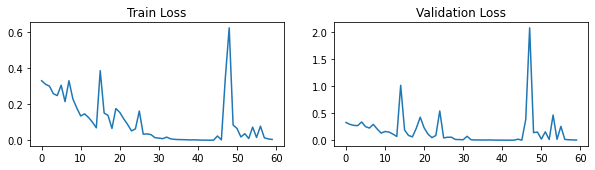

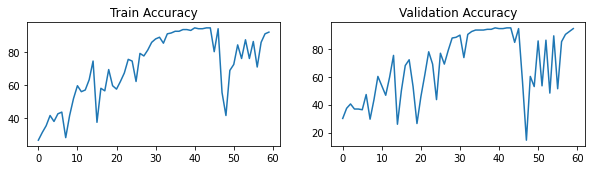

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(accs_valid)

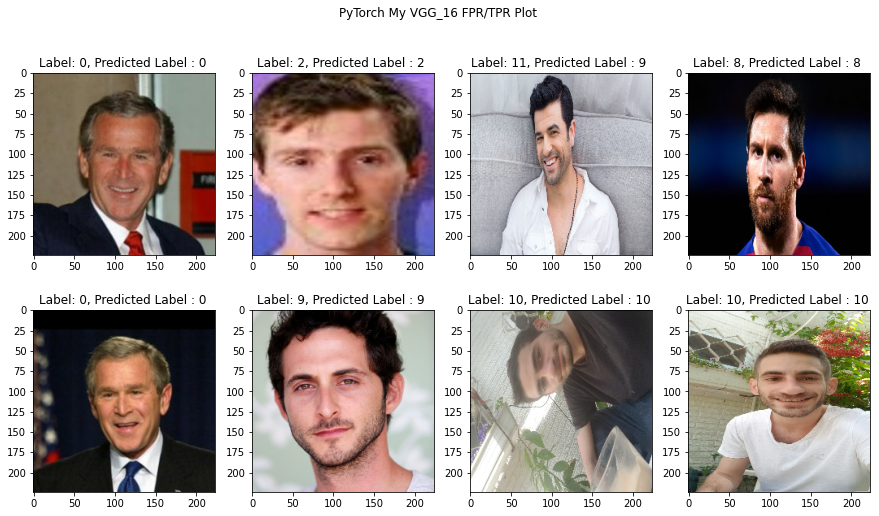

In [25]:
plot_tpr_fpr(model,'PyTorch My VGG_16')

# PyTorch Pre-Trained Models
We have requested to import pytorch pre-trained models and to train them to our dataset, validation them and plot accuracies scores and loss functions scores.
I have chosen VGG16 Model (to compare the results),AlexNet,ResNet152,GoogleNet and MobileNet V3 Large models.
Let's see the results ..

### PyTorch VGG16 Classification

In [26]:
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier._modules['6'] = nn.Linear(4096, len(labels_index))
model_vgg16.cuda()
opt = optim.Adagrad(model_vgg16.parameters())
op2 = optim.Adam(model_vgg16.parameters())
criterion = FocalLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
pytorch_VGG16_losses_train = []
pytorch_VGG16_losses_valid = []
pytorch_VGG16_accs_train = []
pytorch_VGG16_accs_valid = []
EPOCHS = 30
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,model_vgg16,criterion,opt,e)
  pytorch_VGG16_losses_train.append(loss_train)
  pytorch_VGG16_accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,model_vgg16,criterion,opt,e)
  pytorch_VGG16_losses_valid.append(loss_valid)
  pytorch_VGG16_accs_valid.append(acc_valid)

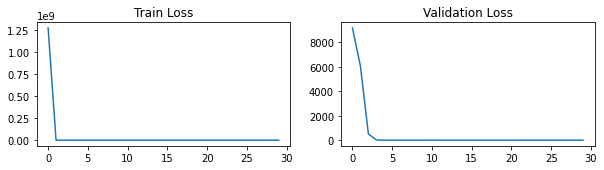

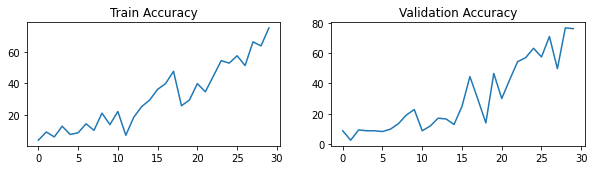

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(pytorch_VGG16_losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(pytorch_VGG16_losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(pytorch_VGG16_accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(pytorch_VGG16_accs_valid)

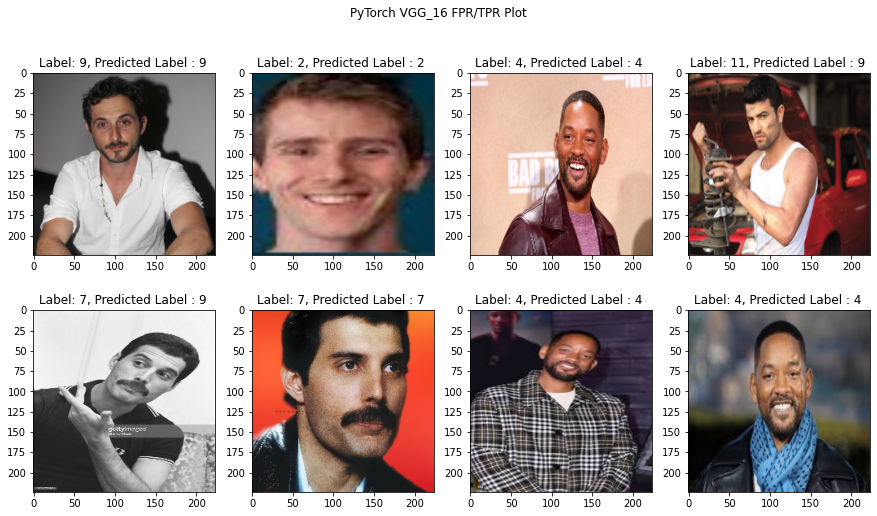

In [33]:
plot_tpr_fpr(model_vgg16,'PyTorch VGG_16')

### PyTorch GoogleNet 

In [28]:
googleNet = models.googlenet(pretrained=True)
googleNet.fc = nn.Linear(1024, len(labels_index))
googleNet.cuda()
opt = optim.Adagrad(googleNet.parameters())
op2 = optim.Adam(googleNet.parameters())
criterion = FocalLoss()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
pytorch_GoogleNet_losses_train = []
pytorch_GoogleNet_losses_valid = []
pytorch_GoogleNet_accs_train = []
pytorch_GoogleNet_accs_valid = []
EPOCHS = 30
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,googleNet,criterion,opt,e)
  pytorch_GoogleNet_losses_train.append(loss_train)
  pytorch_GoogleNet_accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,googleNet,criterion,opt,e)
  pytorch_GoogleNet_losses_valid.append(loss_valid)
  pytorch_GoogleNet_accs_valid.append(acc_valid)

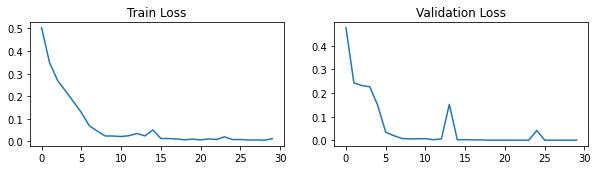

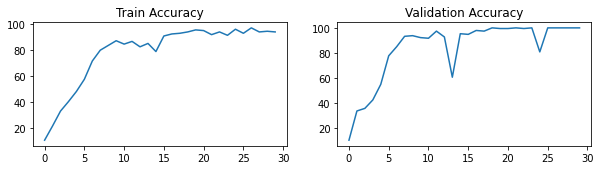

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(pytorch_GoogleNet_losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(pytorch_GoogleNet_losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(pytorch_GoogleNet_accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(pytorch_GoogleNet_accs_valid)

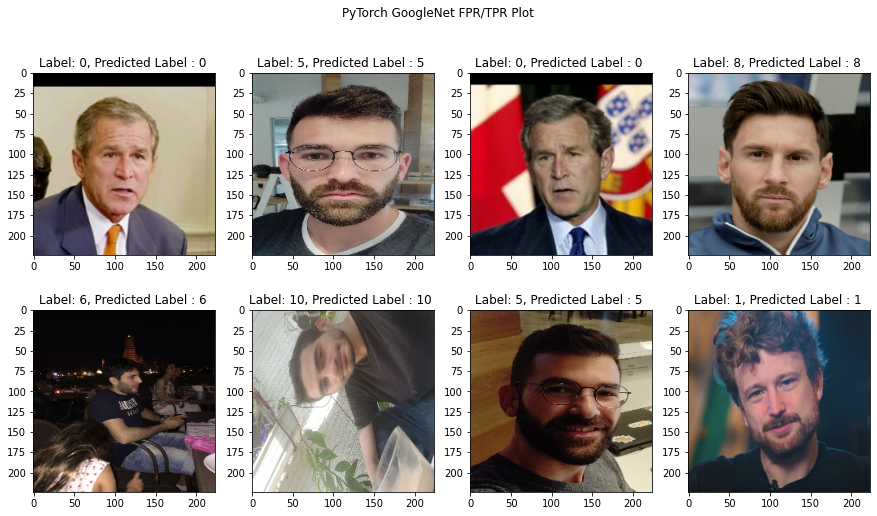

In [36]:
plot_tpr_fpr(googleNet,'PyTorch GoogleNet')

### ResNet-152

In [30]:
resnet152 = models.resnet152(pretrained=True)
resnet152.fc = nn.Linear(2048, len(labels_index))
resnet152.cuda()
opt = optim.Adagrad(resnet152.parameters())
op2 = optim.Adam(resnet152.parameters())
criterion = FocalLoss()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
pytorch_ResNet152_losses_train = []
pytorch_ResNet152_losses_valid = []
pytorch_ResNet152_accs_train = []
pytorch_ResNet152_accs_valid = []
EPOCHS = 30
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,resnet152,criterion,opt,e)
  pytorch_ResNet152_losses_train.append(loss_train)
  pytorch_ResNet152_accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,resnet152,criterion,opt,e)
  pytorch_ResNet152_losses_valid.append(loss_valid)
  pytorch_ResNet152_accs_valid.append(acc_valid)

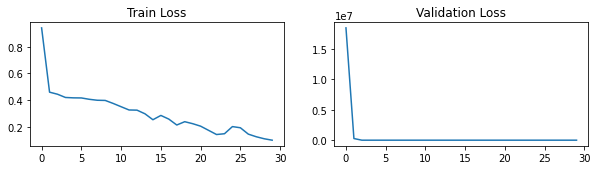

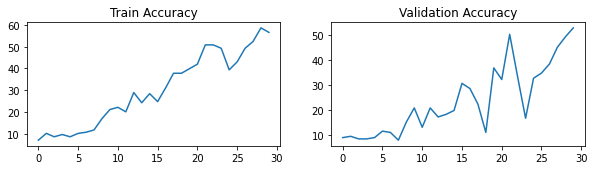

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(pytorch_ResNet152_losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(pytorch_ResNet152_losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(pytorch_ResNet152_accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(pytorch_ResNet152_accs_valid)

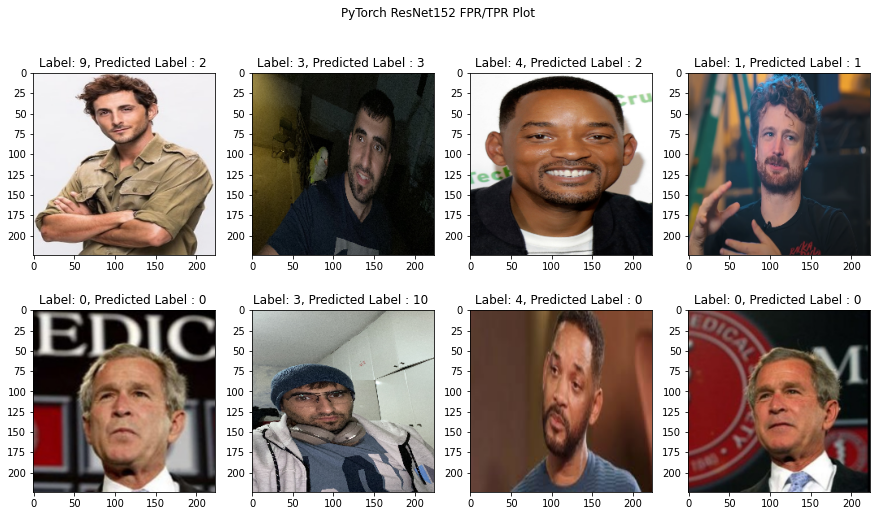

In [40]:
plot_tpr_fpr(resnet152,'PyTorch ResNet152')

### PyTorch AlexNet

In [32]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier._modules['6'] = nn.Linear(4096, len(labels_index))
alexnet.cuda()
opt = optim.Adagrad(alexnet.parameters())
op2 = optim.Adam(alexnet.parameters())
criterion = FocalLoss()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
pytorch_AlexNet_losses_train = []
pytorch_AlexNet_losses_valid = []
pytorch_AlexNet_accs_train = []
pytorch_AlexNet_accs_valid = []
EPOCHS = 30
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,alexnet,criterion,opt,e)
  pytorch_AlexNet_losses_train.append(loss_train)
  pytorch_AlexNet_accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,alexnet,criterion,opt,e)
  pytorch_AlexNet_losses_valid.append(loss_valid)
  pytorch_AlexNet_accs_valid.append(acc_valid)

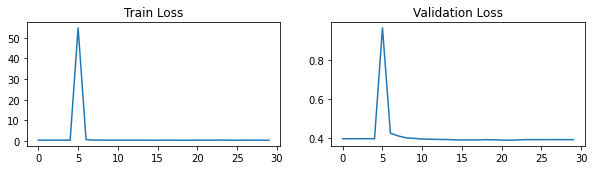

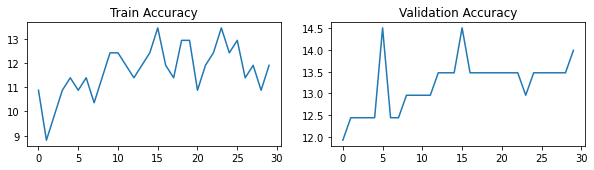

In [57]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(pytorch_AlexNet_losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(pytorch_AlexNet_losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(pytorch_AlexNet_accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(pytorch_AlexNet_accs_valid)

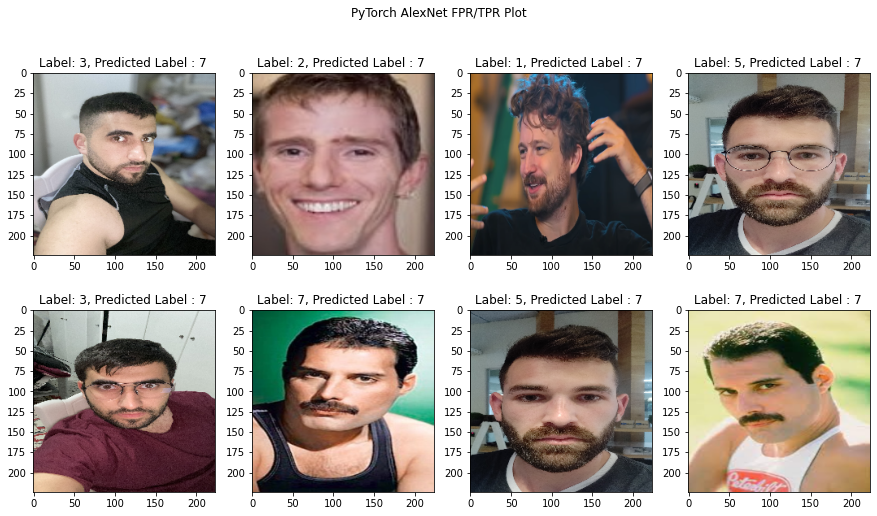

In [49]:
plot_tpr_fpr(alexnet,'PyTorch AlexNet')

### PyTorch MobileNet V3 Large

In [34]:
mb3 = models.mobilenet_v3_large(pretrained=True)
mb3.classifier._modules['3'] = nn.Linear(1280, len(labels_index))
mb3.cuda()
opt = optim.Adagrad(mb3.parameters())
op2 = optim.Adam(mb3.parameters())
criterion = FocalLoss()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


In [ ]:
pytorch_mb3_losses_train = []
pytorch_mb3_losses_valid = []
pytorch_mb3_accs_train = []
pytorch_mb3_accs_valid = []
EPOCHS = 30
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,mb3,criterion,op2,e)
  pytorch_mb3_losses_train.append(loss_train)
  pytorch_mb3_accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,mb3,criterion,op2,e)
  pytorch_mb3_losses_valid.append(loss_valid)
  pytorch_mb3_accs_valid.append(acc_valid)

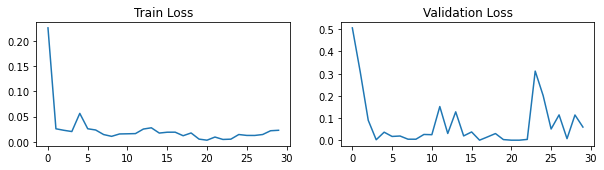

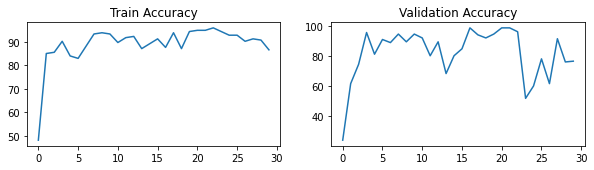

In [47]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(pytorch_mb3_losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(pytorch_mb3_losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(pytorch_mb3_accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(pytorch_mb3_accs_valid)

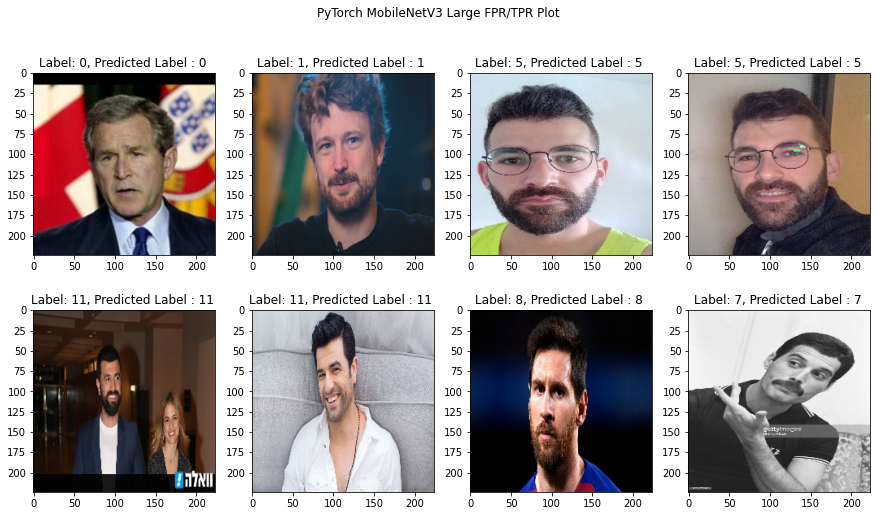

In [50]:
plot_tpr_fpr(mb3,'PyTorch MobileNetV3 Large')

# Ensemble
Another part of the exercise is building an ensemble that combines the five pre-trained models from pytorch and shows the ensemble results are better than the results of each model alone.

In [58]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB,modelC,modelD,modelE, nb_classes=len(labels_index)):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelA
        self.modelD = modelB
        self.modelE = modelA

        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()
        self.modelC.fc = nn.Identity()
        self.modelD.fc = nn.Identity()
        self.modelE.fc = nn.Identity()
        
        # Create new classifier
        self.classifier = nn.Linear(1280+4096+2048+1024+4096, nb_classes)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x.clone())
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x.clone()) 
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x.clone())
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)
        x = torch.cat((x1, x2,x3,x4,x5), dim=1)
        
        x = self.classifier(F.relu(x))
        return x



In [59]:
models = [mb3,alexnet,googleNet,resnet152,model_vgg16]
for model in models:
  for param in model.parameters():
    param.requires_grad_(True)

In [60]:
ensemble = MyEnsemble(mb3,alexnet,googleNet,resnet152,model_vgg16).cuda()
opt = optim.Adagrad(ensemble.parameters())
op2 = optim.Adam(ensemble.parameters())
criterion = FocalLoss()

In [ ]:
ensemble_losses_train = []
ensemble_losses_valid = []
ensemble_accs_train = []
ensemble_accs_valid = []
EPOCHS = 30
for e in range(EPOCHS):
  loss_train,acc_train = train(ds_loader,mb3,criterion,op2,e)
  ensemble_losses_train.append(loss_train)
  ensemble_accs_train.append(acc_train)
  loss_valid,acc_valid = validation(ds_loader,mb3,criterion,op2,e)
  ensemble_losses_valid.append(loss_valid)
  ensemble_accs_valid.append(acc_valid)

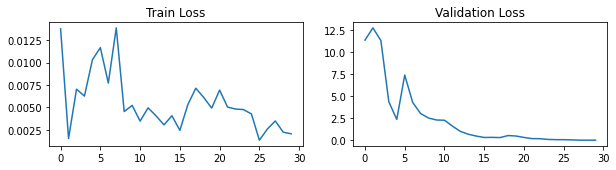

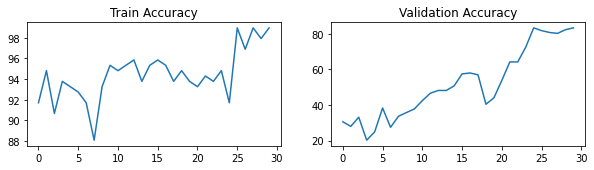

In [63]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title("Train Loss")
plt.plot(ensemble_losses_train)

plt.subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(ensemble_losses_valid)

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.title("Train Accuracy")
plt.plot(ensemble_accs_train)

plt.subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(ensemble_accs_valid)

# Summary
First, my implementation of VGG16 model shows pretty results relative to not pre-trained model - The accuracy rate reached 93%, which is great!

Second, the pre-trained models from PyTorch Models were a little challenging - changing the last classifier layer from 1000 output features to my output features took few hours to find the solution. But in the end, everyone reached great scores except ResNet152, having reached a 50% accuracy rate and AlexNet was totally a failure, 15% accuracy rate.

Final part was to build an ensemble that have combined the five pre-trained models from pytorch and shows the ensemble results are better than the results of each model alone, and that's correct , relate to AlexNet and ResNet152 who were not with high accuracies - the ensemble reached to very high accuracy rate.